In [1]:
# Import packages.
import sys
import numpy as np
import time
import gzip
import shutil
import re

try:
    logaddexp = np.logaddexp
except AttributeError:
    def logaddexp(logx, logy):
        if logy - logx > 100:
            return logy
        elif logx - logy > 100:
            return logx
        minxy = min(logx, logy)
        return minxy + np.log(np.exp(logx - minxy) + np.exp(logy - minxy))

# Print versions of our libraries.
print('numpy', np.__version__)
print('gzip', np.__version__)
print('shutil', np.__version__)
print('re', np.__version__)

numpy 1.22.3
gzip 1.22.3
shutil 1.22.3
re 1.22.3


---
# Function Descriptions

---
### `genotype_matrix_windows()`
#### Purpose:
`genotype_matrix_windows()` is a helper function that splits a genotype matrix into non-overlapping windows and assigns positions that are variable across populations to a window according to their position. By default, the length of the simulated genome is 20 million base pairs. Each window is 500 base pairs long, with inclusive/exclusive bounds (ex. [0,500]). This results in 40,000 windows ranging from [0, 20,000,000].
#### Input:
- `variant_positions`: an array of the positions of variant sites across populations. Each index represents a separate variant (ordered by relative position but not evenly spaced), and its corresponding cell value represents the location of that variant position on the genome.
- `polarized_genotype_matrix`: an array of multiple populations. It includes the ancestral population whose introgression is being inferred (Neanderthals), the population in whom introgression is being tested (Europeans), one or more sister populations to the one being tested, as a control (Africans), and an "ancestral state" reference population against which the rest can be polarized (Chimpanzee). Only biallelic sites are included. The ancestral allele and all identical populations are represented by '0' while the derived mutated allele is represented by '1'.
- `window_size` The size of each window here is set to 500 by default. In Prufer's 2014 paper, the team used a genetic map, with crossover positions. We will map the genetic position by relative physical location on the chromosome \[0 to 20,000,000).
- `sequence_length`: the length of the simulated genome being tested. Set to 20,000,000 by default.

#### Output:
`windows` (dictionary). It has the following key ==> value relationship:

*Window number (from 1 to 40,000) => [window start position, window end position, index of variant position in the input array].*

Types are:
`int => array[int, int, int...]`

If there are multiple variant positions within a window, their indices in the input array of variant positions are appended to the value array.

In [76]:
def genotype_matrix_windows(
        variant_positions,
        polarized_genotype_matrix,
        window_size=500,
        sequence_length=20_000_000,
):
    # Intialize a dictionary with the start and stop position for each window.
    windows = {}
    index = 1
    # Create consistent-length windows spanning the length of the sequence
    for window_start in range(0, int(sequence_length), int(window_size)):
        # The index (window number) is set as the key to a value of an array which contains its start and stop position
        windows[index] = [window_start, (window_start + window_size)]
        index += 1
    # Locate and assign each variant position to its respective window
    # keeps track of index number in the variant_position array
    index = 0
    pos = variant_positions[index]
    for key in windows:
        # extract the window bounds
        start, stop = windows[key]
        # "bin" the variant a the window if it is within bounds
        while start <= pos < stop:
            # append the index of the variant position to the corresponding value array in windows
            windows[key].append(index)
            index += 1
            if index < len(variant_positions):
                pos = variant_positions[index]
            else: # (all variant positions have been binned)
                break
    # window # (1-40,000) -> [0 (start), 500 (stop), index of local variable positions (if any)]
    return windows

---
### `calc_window_intro_percent()`
#### Purpose:
`calc_window_intro_percent()` stores the locations of genomic regions that are a result of the archaic population introgression that the HMM will infer. Known as "true introgression positions," these segments represent the hidden states of the HMM. In practice, the exact loci in modern human DNA that are a result of Neanderthal introgression cannot be known, so in order to evaluate the model's efficacy and compare its performance, we record the true introgression positions during data simulation to create an "answer key".

To this end, this function creates a dictionary of windows similar to the one created by `genotype_matrix_windows()`, but instead of recording the bounds and variant positions of each window, it represents how much each window is covered by a segment of "true introgression" as a percentage value. The data structure allows the quick identification of areas of true introgression in the genome, which allows the HMM's accuracy to be evaluated.

#### Input:
- `Binned_windows`: a dictionary where the keys represent the iwndow number from 1 to 40,000 and the values are arrays where the first two elements represent positional boundaries, and any following elements represent the index of variant positions that lie within that window in the `variant_positions` array. Binned_windows is the direct output of `genotype_matrix_windows`.
- `true_introgression_positions`: nparray representing the locations of introgressed loci on the genome. Each row represents a different introgressed segment. The first column represents its starting location, and the second column represents its stopping location.

#### Output:
- `Win_intro_percent`: a dictionary of 500 base pair bins and their contents included to keep track of the true introgression state windows. The key is the window number and the value is a float percentage between 0 and 1 of how much of the window is covered by the true introgression segment.

In [77]:
def calc_window_intro_percent(Binned_windows, true_introgression_positions):

    Windows = Binned_windows
    true_intro_pos = true_introgression_positions
    
    # Initializing dictionary of Window Introgression Percentages
    Win_intro_percent = {}
    # Extract the columns into numpy arrays and round.
    # Sorting makes iterating easier. Not changing any start positions. intro_starts is 'official' starting position
    intro_starts = np.sort(np.round(true_intro_pos[:, 0]))
    intro_stops = np.sort(np.round(true_intro_pos[:, 1]))
    intro_sizes = np.sort(intro_stops - intro_starts)

    # The index of the true introgression segment in start/stop/sizes
    intro_index = 0
    for key in Windows:
        # if intro_index is the same as the number of true introgressed segments, we can end and assign the rest 0
        if intro_index == intro_sizes.shape[0]:
            Win_intro_percent[key] = 0.
        else:
            # Tracking indices
            # integer starting and ending positions of the true introgressed segments
            curr_start = int(intro_starts[intro_index])
            curr_stop = int(intro_stops[intro_index])
            # integer offset of curr_start and curr_stop from most recent window
            curr_start_mod = int(intro_starts[intro_index] % 500)
            curr_stop_mod = int(intro_stops[intro_index] % 500)
            # current window that contains the beginning or end of the current segment
            curr_start_window = int(((curr_start - curr_start_mod) / 500) + 1)
            curr_stop_window = int(((curr_stop - curr_stop_mod) / 500) + 1)
            # boolean that tracks whether the segment falls completely within a window (exception)
            tiny_intro = curr_stop - curr_start < 500
            # skips windows that come before the current start window
            if key < curr_start_window:
                Win_intro_percent[key] = 0.
            elif key == curr_start_window:
                # If the introgressed segment is less than 500, we need to do a special case to find the percentage
                if tiny_intro:
                    Win_intro_percent[key] = (curr_stop - curr_start) / 500
                    # since this counts as a whole segment, we have to tick the index to seach for the next segment
                    intro_index += 1
                else:  # normal case, the true introgressed segment is over 500 base pairs long
                    # calculates the % of the window that is covered by the segment from curr_start to the window's end
                    Win_intro_percent[key] = (Windows[key][1] - curr_start) / 500
            # In the middle of the introgressed segment, so each window is 100% covered
            elif curr_start_window < key < curr_stop_window:
                Win_intro_percent[key] = 1.
            # In the last window containing the segment. It should be partially introgressed.
            elif key == curr_stop_window:
                # calculates the % of the window that is covered by the segment from the window's start to curr_stop
                Win_intro_percent[key] = (curr_stop - Windows[key][0]) / 500
                # since we found the stop window of a large segment, we can move onto the next segment, if any
                intro_index += 1
                # check to make sure that we record the same number of windows as there are segments
                if intro_index > intro_sizes.shape[0]:
                    print("ERROR: Recorded more windows than there are segments")
                    break
            else:  # Error check
                print("----------------------")
                print("ERROR: bug in key iteration for calculation of introgression percentages")
                print("----------------------")
                break

    return Win_intro_percent

---
### `logsum()`
#### Purpose: 
`logsum()` takes the numpy builtin function `numpy.logaddexp()` and expands its usage to multidimensional arrays. `numpy.logaddexp()` is used to calculate the logarithm of the sum of exponentiations of the inputs. This is useful in statistical methodologies where the calculated probabilites of events become so small they exceed the range of floating point numbers and the computer loses information by rounding them to zero.

In this model, some derived values can be smaller than 1*10^-130.

In cases like these,  calculation values are stored as the logarithm of the true probability. `logaddexp()` allows such probabilities to be added, as in the format `log(exp(arr1) + exp(arr2))`. 

`logsum()` is a more flexible version which can take in multidimensional arrays as valid input by stringing all data into a one-dimensional array by appending rows one after another. `logaddexp()` only typically works on a 1-dimensional array `[1, 2, 3, 4]`, but `logsum()` accounts for the case of multiple dimensions by converting the input into the 1-D format that `logaddexp()` can recognize: for example, by convering the array `[[1, 2], [3, 4]]` into the proper dimensions before `logaddexp()` is called. `logsum()` can still take in 1-D arrays as input.

#### Input:
- `array`: a numpy array, either of one or multiple dimensions.

#### Output:
- `sum`: the sum of log probabilities within the array, in log form

In [78]:
def logsum(array):
    # If the array is of multiple dimensions, it is 'flattened' along one dimension
    if len(array.shape) > 1:
        vec = np.reshape(array, (np.product(array.shape),))
    else:
        vec = array
    # the recurrence relation has to include a base case
    # before the sum is initialized the base case is negative infinity,
    # which has an underlying probability of zero from a logaddexp perspective
    sum = np.NINF
    for num in vec:
        sum = logaddexp(sum, num)
    return sum

---
### `calc_alpha()`

#### Purpose:
In the context of a HMM, the forward variable, or $\alpha$, gives the probability of being in a certain state after observing some prefix of the emission sequence. A prefix refers to some number $t$ characters starting from the beginning of the observed sequence.

Starting by having "seen" none of these characters and iteratively building on these probabilities, the alpha matrix answers the question: "What is the probability that we will be in each state after having seen $t$ characters of the observed sequence?" `calc_alpha()` creates this matrix so that the forward variable is calculated for all positions in the observed sequence.

#### Input:
- `A`: a 2x2 array of state transition probabilities
- `B`: a 2x2 array of observation emission probabilities
- `pi`: a 2x1 arry of initial state probabilities
- `Ob`: a string representing the observed sequence (binary-encoded numbers indexed to labels: 0="N", 1="C")
- `N`: the number of states (in this case, 2: {Species, Introgressed})
- `T`: the length of the observed sequence (set to 40,000)

#### Output:
- `alpha`: a matrix that stores the forward variable alpha, which is the probability of observing some prefix of length `t` of the emission sequence and being in some given state `j` at the end of the prefix. `alpha[t][j]` gives the probability of observing the first `t` characters of the sequencing and ending at state `j`. It has dimensions `(T+1) X N` because the first row represents the state after 0 prefix characters, which is the same as the initial distribution likelihood - found in `pi`.

The following is a visual representation of the alpha matrix. The first row and first column are for labeling purposes only. Note that the values in the last row comprise the total probability of the observed sequence being produced by the HMM, and the matrix is filled from top to bottom.

| Prefix Length | State 0 (ends in Species) | State 1 (ends in Introgressed) |
| --- | --- | --- |
| t=0 | P(first state is S) | P(first state is I) |
| t=1 | P(ends at state S \| seen 1 observation) | P(ends at state I \| seen 1 observation) |
| t=2 | P(ends at state S \| seen 2 observations) | P(ends at state I \| seen 2 observations) |
...
| T=40,000 | P(ends at state S \| seen 40k observations) | P(ends at state I \| seen 40k observations) |

In [79]:
def calc_alpha(A, B, pi, Ob, N, T):
    
    # Must be T+1 columns in the alpha matrix bc the top one is the state after 0 prefix characters
    # This is the same as the initial distribution likelihood found in pi
    alpha = np.zeros((T + 1, N))
    # initialize the first row to be the initial distribution values
    # represents the probabilities of being in some state (S/1st or I/2nd) before seeing any (t=0) observed emissions
    alpha[0, :] = pi
    
    # Compute each row, starting with 2nd row. 1st row filled in last step.
    # t counts the character number in the sequence.
    for t in range(1, T + 1):
        
        # k stores the character of the previous observed emission
        k = Ob[t - 1]
        # Compute each column, starting with 1st (Species state) then 2nd (Introgression state)
        for j in range(N):
            
            # Placeholder is set to negative infinity the first time each cell is encountered, resetting it.
            # It stores a probability interpreted by logaddexp as zero when calculating the first logsum
            lprob = np.NINF
            # The i loop occurs in a single cell, the variable iterating over the states in the previously-calculated row
            # Inside the cell, calculate the sum of probabilities (in log form) of the transitions from all possible
            # previous states in time t-1 (the previous row) into the new state j.
            # In this case, N=2, meaning there were 2 possible previous states that could have led to the current one
            # This code answers: "What is the probability that each possible scenario (previous state being S or I) led to
            # our current state j?" When the loop is finished, the value of the cell is set to the combination of those probabilities.
            for i in range(N):
                
                # lp represents a sum of log probabilities:
                # (forward variable at time t-1 for state i)
                # + likelihood that last row's state i transitioned to this state j using the transition matrix A
                # + the likelihood that state i emitted this observed character k using the emission matrix B
                lp = alpha[t - 1][i] + A[i][j] + B[i][k]
                # during the first iteration, lprob is reset as equal to lp, as lprob starts set to NINF
                # the second time around, lp is recalculated and represents the probability that the current state j
                # was reached from the Introgressed state. Now, calling logaddexp(lprob, lp) represents the sum of these:
                # (prob we're in state j if the last state was S + prob we're in state j if the last state was I)
                lprob = logaddexp(lprob, lp)
                
            # After the probabilities based on both of the cells in the previous row were treated and combined,
            # the final number is set as the forward variable:
            # the likelihood we observe prefix (...t) of the observe sequence and end up in state j
            alpha[t][j] = lprob
    return alpha

---
### `calc_beta()`

#### Purpose:
In the context of a HMM, the backward variable, or beta, gives the probability of being in a certain state `j` just before observing a suffix of the emission sequence of length `t`. A suffix refers to some number `t` of the last characters in the sequence. Starting by having "seen" none of these chraracters and building on its own probabilities in reverse order, the beta matrix answers the question: "What is the probability of being in state `j` right before the last `T-t` characters of the observed sequence (where `T` is the length of the sequence)?" `calc_beta()` creates this matrix so that the backward variable is calculated for all positions in the observed sequence.


#### Input:
- `A`: a 2x2 array of state transition probabilities
- `B`: a 2x2 array of observation emission probabilities
- `pi`: a 2x1 arry of initial state probabilities
- `Ob`: a string representing the observed sequence (binary-encoded numbers indexed to labels: O=N, 1=C)
- `N`: the number of states (in this case, 2: {Species, Introgressed})
- `T`: the length of the observed sequence (set to 40,000)

#### Output:
- `beta`: a matrix that stores the backward variable beta, which is the probability of being in some given state `j` before observing some suffix of length `t` of the emission sequence. `beta[t][j]` gives the probability of being in state `j` before seeing a suffix of length `t`. There must be `T+1` columns in the beta matrix because the final row (which is filled first in the calculation) represents the state chances before 0 suffix characters have been observed. The initial state is assumed as given (prior probability = 100%), so its value is 1. 

The following is a visual representation of the beta matrix. The first row and first column are for labeling purposes only. Note that the values in the top row comprise the total probability of each state preceding the entire observed sequence, and the matrix is filled from bottom to top.

| Suffix Length | State 0 (came from Species) | State 1 (came from Introgressed) |
| --- | --- | --- |
| t=0 | P(will see all 40k observations \| after S) | P(will see all 40k observations \| after I) |
...
| t=39,998 | P(will see last 2 observations \| after S) | P(will see last 2 observations \| after I) |
| t=39,999 | P(will see last 1 observation \| after S) | P(will see last 2 observation \| after I) |
| t=40,000 | P(will see last 0 observations \| after S) | P(will see last 0 observations \| after I) |

In [80]:
def calc_beta(A, B, Ob, N, T):
    # Must be T+1 columns in the beta matrix because the bottom one is the state before a 0-character suffix
    # This is given as 100% in the base case, so we still initialize the matrix to zeroes.
    # This is because the underlying proability assumed by the logaddexp occurrence is 1 (log(1) = 0).
    beta = np.zeros((T + 1, N))
    
    # Compute each row, starting with the 2nd from the bottom. The bottom row was filled out during initialization.
    # t counts the position of the state relative to the sequence
    for t in range(T - 1, -1, -1):
        
        # k stores the character just after (emitted by) the state being investigated
        k = Ob[t]
        # Compute each column, starting with 1st (Species state) then 2nd (Introgression state)
        for j in range(N):
            
            # Placeholder is set to negative infinity the first time each cell is encountered, resetting it.
            # It stores a probability interpreted by logaddexp as zero when calculating the first logsum
            lprob = np.NINF
            # The i loop occurs in a single cell, the variable iterating over the states in the previously-calculated row
            # Inside the cell, calculate the sum of probabilities (in log form) of the transitions from all possible
            # previous states in time t+1 (the previous/lower row) to the current row t.
            # This code answers: "What is the probability that each state was arrived at through the emission of
            # the most recent suffix character k from our current state in column j and a subsequent transition
            # from state j to i?" When the loop is finished, the value of the cell is set to the combination of those probabilities.
            for i in range(N):
                
                # lp represents a sum of log probabilities:
                # (backward variable at time t+1 for state i)
                # + likelihood that the lower row's state i transitioned to this state j using the transition matrix A
                # + the likelihood that state i emitted this observed character k using the emission matrix B
                lp = beta[t + 1][i] + A[j][i] + B[j][k]
                # during the first iteration, lprob is reset as equal to lp, as lprob starts set to NINF
                # the second time around, lp is recalculated and represents the probability that the current state j
                # transitioned the Introgressed state. Now, calling logaddexp(lprob, lp) represents the sum of these:
                # (prob we're in state j if the next state is S + prob we're in state j if the next state is I)
                lprob = logaddexp(lprob, lp)
                
            # After the proababilities based on both of the cells in the lower row were treated and combined,
            # the final number is set as the backward variable:
            # the likelihood we observe suffix(t...) of the observed sequence as a result of state j
            beta[t][j] = lprob
    return beta

___
### `calc_xi()`

#### Purpose:
In the context of a HMM, the xi variable gives the probability of being in a certain state state `i` at time `t` and state `j` at time `t + 1`. One can imagine the xi matrix as leveraging the forward and backward variables to calculate the probabilities of a transition between all possible pairs of hidden states between every two positions in the observed sequence. The xi matrix answers the question: "What is the probability that the state transition `i` to `j` occurred from position `t` to position `t + 1`?"

#### Input:
- `A`: a 2x2 array of state transition probabilities
- `B`: a 2x2 array of observation emission probabilities
- `Ob`: a string representing the observed sequence (binary-encoded numbers indexed to labels: O=N, 1=C)
- `N`: the number of states (in this case, 2: {Species, Introgressed})
- `T`: the length of the observed sequence (set to 40,000)
- `alpha`: the matrix containing the forward variable, calculated by `calc_alpha`
- `beta`: the matrix containing the backward variable, calculated by `calc_beta`

#### Output:
- `xi`: a matrix where `xi[i][j][t]` gives the probability of being in state `i` at time `t` and transitioning to state `j` at time `t + 1`. and transitioning to state `j` at time `t`.

The following is a visual representation of `xi`. The first row and first column are for labeling purposes only. `xi` is a three-dimensional matrix (2 X 2 X 40,000), so I've simplified it into a visual representation here. Each row corresponds to a different time or transition position between two adjacent observed characters, filled out from top to bottom (as with `alpha`). One can imagine the second table as the "back side" of `xi`, existing directly behind the front side in a stack, like a second sheet of paper. This model reflects how the matrix is instantiated. One can think of the whole data structure as a `NxN` (2x2) tall "tower" which is `T` (40,000) stories high. The inner loops will begin at coordinates `(0, 0)` on the "top floor" (T-level) and visit every "room" on that floor in a counterclockwise fashion, going down a floor when all four rooms have been evaluated. The "top floor" here is t=0, which represents the first state transition associated with the observed sequence. `Ob[t]` and `Ob[t+1]` here refer to the adjacent observations in the sequence at the transition position being analyzed.

`xi` (Front Side):

| Transition | State S went to State S | State S went to State I |
| :--- | :--- | :--- |
| t=0 | P(S -> S \| `Ob[0]` -> `Ob[1]`) | P(S -> I \| `Ob[0]` -> `Ob[1]`) |
...
| t=39,997 | P(S -> S \| `Ob[39,997]` -> `Ob[39,998]`) | P(S -> I \| `Ob[39,997]` -> `Ob[39,998]`) |
| t=39,998 | P(S -> S \| `Ob[39,998]` -> `Ob[39,999]`) | P(S -> I \| `Ob[39,998]` -> `Ob[39,999]`) |
| t=39,999 | P(S -> S \| `Ob[39,999]` -> end) | P(S -> I \| `Ob[39,999]` -> end) |

`xi` (Back Side):


| Transition | State I -> State S | State I -> State I |
| :--- | :--- | :--- |
| t=0 | P(I -> S \| `Ob[0]` -> `Ob[1]`) | P(I -> I \| `Ob[0]` -> `Ob[1]`) |
...
| t=39,997 | P(I -> S \| `Ob[39,997]` -> `Ob[39,998]`) | P(I -> I \| `Ob[39,997]` -> `Ob[39,998]`) |
| t=39,998 | P(I -> S \| `Ob[39,998]` -> `Ob[39,999]`) | P(I -> I \| `Ob[39,998]` -> `Ob[39,999]`) |
| t=39,999 | P(I -> S \| `Ob[39,999]` -> end) | P(I -> I \| `Ob[39,999]` -> end) |

In [81]:
def calc_xi(A, B, Ob, N, T, alpha, beta):
    # Must be T columns in the xi matrix because there are T-1 transitions between observed characters,
    # plus one state change from the state that emitted the last character to final state.
    xi = np.zeros((T, N, N))
    
    # Compute each 2x2 row or "floor" of the matrix from top to bottom. t=0 represents the first transition between observations
    for t in range(T):
        k = Ob[t]
        lp_traverse = np.zeros((N, N))
        
        # These loops will circle each "floor" and calculate each cell at the [i, j]th coordiante of that floor based
        # on the corresponding alpha and beta matrix positions and the transition and emission matrices
        for i in range(N):
            for j in range(N):
                
                # lp, or the probability of this transition, is equal to the sum of
                # P(getting to this state)
                # P(making this transition)
                # P(emitting this character)
                # P(going to the end)
                lp = (
                        alpha[t][i]
                        + A[i][j]
                        + B[i][k]
                        + beta[t + 1][j]
                )
                lp_traverse[i][j] = lp

        # Each "room" on floor t has been calculated. Now that we have the values of all four cells, we can calculate
        # the total probability of all cases on the top floor as the sum of logarithm probabilities within it.
        # When the "floor" loop is over, this next step "subtracts the logs" (divides the probabilities) of each cell
        # by the total probability of floor T.
        # Normalize the probability for this time step (divide by P(O|lambda))
        xi[t, :, :] = lp_traverse - logsum(lp_traverse)
    return xi

---
### `calc_gamma`

#### Purpose:
In the context of a HMM, the gamma variable gives the probability of being in a certain state state `i` at time `t`. This is the final variable in the workflow, as it gives the probability of Human/Neanderthal ancestry for any locus. The gamma variable answers the question: "What is the probability that the observed locus at time `t` was a result of hidden state ancestry `i`?"

#### Input:
- `xi`: the matrix containing the xi variable, calculated by `calc_xi`
- `N`: the number of states (in this case, 2: {Species, Introgressed})
- `T`: the length of the observed sequence (set to 40,000)

#### Output:
- `gamma`: a matrix where `gamma[t][i]` gives the probability of being in state `i` at time `t`.



The following is a visual representation of `gamma`. The first row and first column are for labeling purposes only. Since hidden state 1 (Introgressed) refers to a likely Neanderthal ancestry, we take the right column `gamma[t][1]` of this matrix as the HMM's guess that the hidden state at this location in the sequence is a result of Neanderthal introgression. `Ob[t]` refers to the observation in the sequence at the locus being analyzed.


| Observation (500-bp locus) | State 0 (Species) | State 1 (Introgressed) |
| --- | --- | --- |
| t=0 | P(`Ob[0]` \| S) | **P(`Ob[0]` \| I)** |
| t=1 | P(`Ob[1]` \| S) | **P(`Ob[1]` \| I)** |
| t=2 | P(`Ob[2]` \| S) | **P(`Ob[2]` \| I)** |
...
| t=40,000 | P(`Ob[39,999]` \| S) | **P(`Ob[39,999]` \| I)** |

In [82]:
def calc_gamma(xi, N, T):
    # Must be T columns in the gamma matrix because there are T observed loci
    gamma = np.zeros((T, N))
    
    # Compute each row, starting with the first and going down. Each corresponds to a locus
    for t in range(T):
        
        # Compute each column, starting with the Species state (i=0) and then the Introgressed state (i=1)
        for i in range(N):
            
            # Sum up the probabilities for state i at this position t by combining all relevant instances
            # where the hidden state could be i at time t
            gamma[t][i] = logsum(xi[t, i, :])
    return gamma

---
### `update_A()`

#### Purpose:
This function is used in the Baum-Welch algorithm in order to update the transition matrix based on the real distribution of probabilities that come from the `gamma` calculated by the last iteration of the model. The transition matrix `A[i][j]` is updated by finding the sum of all transitions from positions `i` to `j` (found with `xi`), and the update normalizes this matrix by the sum of the transitions out of state `i` (found with `gamma`). It is important to remember that the HMM does not "know" the true states and their transitions, it is updating its own parameters by observing the frequency of its *guesses* at the true states and adjusting according to probability.

#### Input:
- `N`: the number of states (in this case, 2: {Species, Introgressed})
- `xi`: the matrix containing the xi variable, calculated by `calc_xi`
- `gamma`: the matrix containing the gamma variable, calculated by `calc_gamma`

#### Output:
- `A`: an updated 2x2 transition probability matrix based on the prevalence of transitions between inferred states after analyzing the observed sequence

In [83]:
def update_A(N, xi, gamma):
    # Initialize a blank new transition matrix
    A = np.zeros((N, N))
    # Initialize the sum of all transitions out of i
    trans_out = np.zeros(N)
    
    # for every state i in gamma (Species or Neanderthal)
    for i in range(N):
        # how many transitions out of state i were there
        # summing probabilities because a confidence of 1 counts as 1 transition, 50% confidence counts as half, etc.
        trans_out[i] = logsum(gamma[:, i])
    
    # for every starting state i in xi
    for i in range(N):
        # for every receiving state j in xi
        for j in range(N):
            # A (transition) [i][j] is the sum of all the transitions from i to j
            # This normalized by the previously-calculated sum of the total number of inferred transitions from state i
            A[i][j] = logsum(xi[:, i, j]) - trans_out[i]
            
    return A

---
### `update_B()`

#### Purpose:
This function is used in the Baum-Welch algorithm in order to update the emission matrix based on the real distribution of emissions from inferred true states that come from the `xi` calculated by the last iteration of the model. The transition matrix `A[i][j]` is updated by finding the sum of all transitions out of `i` when emission `k` is observed and dividing by the total number of transitions out of `i`.

#### Input:
- `Ob`: a string representing the observed sequence (binary-encoded numbers indexed to labels: O=N, 1=C)
- `N`: the number of states (in this case, 2: {Species, Introgressed})
- `M`: the number of possible observations (in this case, 2: {N (Not Consistent), C (Consistent)})
- `T`: the length of the observed sequence (set to 40,000)
- `xi`: the matrix containing the xi variable, calculated by `calc_xi`

#### Output:
- `B`: an updated 2x2 emission probability matrix based on the prevalence of emissions from inferred states after analyzing the observed sequence

In [84]:
def update_B(Ob, N, M, T, xi):
    # Initialize a blank new emission matrix
    B = np.zeros((N, M))
    # For every state i
    for i in range(N):
        # Initialize the matrix of all emissions from state i
        # ksum[k] is the sum of all i with k
        ksum = np.zeros(M) + np.NINF
        # for every observed locus t in the sequence
        for t in range(T):
            # set k to the observation at the current locus
            k = Ob[t]
            # for every state j
            for j in range(N):
                # find the sum of all emissions of k from state i when transitioning to each state j and add them
                ksum[k] = logaddexp(ksum[k], xi[t, i, j])
        # Normalize the sum of all emissions of k from that state i by the sum of all emissions at that position
        ksum = ksum - logsum(ksum)
        # Set the new emission matrix to the normalized probability of every type of emission k from state i
        B[i, :] = ksum
    return B

---
### `update_pi`

#### Purpose:
This function is used in the Baum-Welch algorithm in order to update the initial distribution matrix based on the inferred first true state that comes from the `gamma` calculated by the last iteration of the model. The initial distribution matrix `pi[i]` is updated by finding the probability of the first state being state `i` as calculated under the previous model's parameters.

#### Input:
- `N`: the number of states (in this case, 2: {Species, Introgressed})
- `gamma`: the matrix containing the gamma variable, calculated by `calc_gamma`

#### Output:
- `pi`: an updated 1x2 initial distribution probability matrix based on the probability of true states at the first observed locus in the previous model.

In [85]:
# iteratively update pi
def update_pi(N, gamma):
    # Initialize a blank new initial distribution matrix
    pi = np.zeros(N)
    # for every state i
    for i in range(N):
        # The adjusted chances that a observed sequence will start on state i
        # are set to the probability that the first locus was i in the last iteration of the model
        pi[i] = gamma[0][i]
    return pi

---
### `eval_accuracy` (Ignore performance measurement for now)

#### Purpose:
This function measures the performance of an HMM against true introgression positions.

#### Input:
- `true_windows`: numpy array of windows containing introgressed sites measured by percentage coverage. Some sites will have incomplete window edges.
- `tested_HMM`: numpy gamma matrix returned from HMM. Represents likelihood of introgression at position. Should be pre-exponentiated (float probabilities not logs).
- `normalized`: Boolean determining behavior of algorithm (default True). False will evaluate HMM correct "guesses" as they are presented: are they over the threshold or not? True will adjust the HMM "guesses", treating them as relative likelihoods: the highest scoring window is set to 1 and other probabilities are normalized accordingly, then evaluated in relation to the original threshold
- `threshold`: float representing the level of certainty about a true state being introgressed that `gamma` must have in order for the inference to be counted as a guess

#### Output:
- `performance`: numpy array of floats `[false_pos_r, miss_rate, sensitivity, specificity]`
In this context, a "positive" represents a locus that the HMM has inferred to be a result of introgression from Neanderthals above the confidence `threshold`. Whether or not that is true or false depends on the simulated ancestral history of that locus.
- `false_pos_r`: float of "false positive" rate or (# false positivies / (# false positives + # true negatives)). It is the probability that a true negative will test positive given the model (false alarm).
- `miss_rate`: float of "false negative" rate or (# false negatives / (# false negatives + # true positives)). It is the probability that a true positive will test negative given the model (this is expected to happen often, as true introgressed states rarely result in only Consistent-type genomic patterns within a 500 base pair window)
- `sensitivity`: float of "true positive" rate or (# true positives / (# true positives + # false negatives)). It is the probability that a true positive will test positive given the model.
- `specificity`: float aof "true negative" rate or (# true negatives / (# true negatives + # false positives)). It is the probability that a true negative will test negative given the model.

In [86]:
def eval_accuracy(true_windows, tested_HMM, normalized=True, threshold=.9):
    # matrix of windows containing introgressed sites (1. = 100% coveragechira
    tiw = true_windows
    # takes the second column of gamma, which measures the likelihood of Neanderthal ancestry
    gamma = tested_HMM[:, 1]

    # performance values preset to -1 to easily show errors
    false_pos_r = -1
    miss_rate = -1
    sensitivity = -1
    specificity = -1


    # If we need to normalize, change values of gamma such that the highest-scoring site is set to 100%
    if normalized:
        # Find the value of the highest-scoring site in gamma
        max_prob = np.amax(gamma)
        # Multiply every probability in gamma (including the highest-scoring site) by 1/max_prob
        gamma = gamma * (1 / max_prob)

    # Compare gamma and tiw to see if they have the same number of elements (windows)
    if len(tiw) == len(gamma):

        fp = 0  # number of false positives
        fn = 0  # number of false negatives
        tp = 0  # number of true postivies
        tn = 0  # number of true negatives

        # loop through gamma and record the number of true/false positives/negatives
        for w in range(len(tiw)):
            # Underlying window is partially or completely introgressed
            if 0 < tiw[w] <= 1.:
                # true positive
                if gamma[w] >= threshold:
                    tp += 1 # tiw[w]
                # false negative
                else:
                    fn += 1 # tiw[w]
            # Underlying window is not 100% introgressed
            elif tiw[w] == 0:
                # false positive
                if gamma[w] >= threshold:
                    fp += 1 # tiw[w]
                # true negative
                else:
                    tn += 1 # tiw[w]
            # something went wrong and tiw shows a value below zero or above 1
            else:
                print("ERROR in eval: window shows introgression percentage below zero or above 1")

        # check at the end to see if tp + tn + fp + fn == number of windows
        if tp + tn + fp + fn != len(tiw):
            print("ERROR in eval: true positives and true negatives do not sum to the number of windows")
            print(tp + tn + fp + fn)

        # Calculate rates for performance
        print("#tp: " + str(tp) + "\t#tn: " + str(tn), "\t#fp: " + str(fp), "\t#fn: " + str(fn))
        false_pos_r = fp / (fp + tn)
        miss_rate = fn / (fn + tp)
        sensitivity = tp / (tp + fn)
        specificity = tn / (tn + fp)

    else:
        print("ERROR IN EVAL: C column of gamma and true introgressed window array have different number of windows")

    performance = np.array([false_pos_r, miss_rate, sensitivity, specificity])
    return performance


### Not Included Because They Contain More than Other Functions: `extract_O()` and `hmm()`
- `extract_O()` (contains `genotype_matrix_windows()` and `calc_window_intro_percent()`)
- `hmm()` (contains everything else)

---
# Example Workflow Using Simulated Data
---

#### Types of Simulated Data
- var_pos: an nparray of variant positions. Each variant is represented by a new row of the array, and the cell value represents its position in the genome in base pairs
- pol_geno_mat: NOT polarized - in simulations ancestral alleles are known for sure

`position		num_missing_calls		haps_with_missing_calls		locus`

In [13]:
var_pos = np.loadtxt('../sim_example/rep_id_1_var_pos.csv.gz', delimiter=',')
pol_geno_mat = np.loadtxt('../sim_example/rep_id_1_geno_mat.csv.gz', dtype=int,delimiter=',')
true_intro_pos = np.loadtxt('../sim_example/rep_id_1_intro_pos.csv.gz', delimiter=',')

In [14]:
# Generate the window structure and bin variant positions
Windows_pos = genotype_matrix_windows(var_pos, pol_geno_mat, window_size=500, sequence_length=20_000_000)
# Generate another dictionary that contains the true introgression positions
Windows_true = calc_window_intro_percent(Windows_pos, true_intro_pos)

In [15]:
# Initialize observed sequence
obs_seq = []
# Define what C, a pattern consistent with introgression, would look like
# (Polarized genotype matrix order is [AFR1, AFR2, EUR, NEAN] where 0 represents ancestral alleles
c_pattern = np.array([0, 0, 1, 1])

In [16]:
# Iterate through each window by key
for key in Windows_pos:
    # Extract the positions and variants for the window
    window_vals = Windows_pos[key]
    # Print the tracker
    # print('there are {0} variants in window {1}'.format(len(window_vals[2:]), key))
    # If there are variants in the window: (NOTE: Windows with 1 variant are still counted!!)
    # Typically Window[key] gives [start, stop]. If there are 1 or more variants then the len(value)>2
    if len(window_vals) > 2:
        # Extract variable positions in that window. [2:] excludes start pos and end pos
        variants = np.asarray(window_vals[2:], dtype=np.int32)
        # Subset the genotype matrix for that window.
        window_geno_mat = pol_geno_mat[variants, :]
        # print(window_geno_mat)
        # Define what C matrix would look like given an arbitrary number of variants.
        c_mat = np.tile(c_pattern, (window_geno_mat.shape[0], 1))
        # If the C matrix is equal to the windowed matrix declare it consistent.
        if np.array_equal(c_mat, window_geno_mat):
            # print('C')
            obs_seq.append('C')
        # Else declare the window non-consistent.
        else:
            # print('N')
            obs_seq.append('N')
    # If there are no variants in the window declare in non-consistent.
    else:
        # print('N')
        obs_seq.append('N')
# Convert the observation sequence list to an array.
obs_seq_array = np.asarray(obs_seq)

# print('there are {0} many consistent observations'.format(np.count_nonzero(obs_seq_array == 'C')))

### Manually performing `hmm()`

In [17]:
# SETTING UP PRUFER PARAMETERS
s = .0005 # Ancestral switch rate
p = 0.01 # Prior probability for archaic ancestry at any locus (initial distribution)
u = 0.99 # Prior probability of archaic ancestry conditional on all SNPs in the window being of state "C"
threshold = .9 # Probability cutoff for HMM's "guess" at a true state (must be above 90%)
N = 2 # State space (State 0 = 'S' (Species/sapiens), State 1 = 'I' (Introgressed/neandertalensis))
M = 2 # Observation space (Observation 0 = 'N' (not consistent), Observation 1 = 'C' (consistent))
convergence_threshold = 0.01 # Log-likelihood convergence threshold - used to auto-end Baum-Welch
# Setting up other parameters
normalized = False # Does not normalize results based on relative probability
optimization_limit = 100 # Primary Baum-Welch adjustment parameter, to make sure it doesn't overfit
# Note that the Naive HMM is counted as BW#=0, so an optimization_limit of 20 will result in 19 optimizations

In [18]:
# PREPROCESSING
T = len(obs_seq_array) # length of the sequence (40,000)
observation_letters = ['N', 'C'] # index letter observations for future use
# Ob is the same as obs_seq_array, but with 'N' replaced by 0 and 'C' replaced by 1 for quick reference
Ob = [observation_letters.index(label) for label in obs_seq_array]

In [19]:
# SETTING UP HMM
# All calculations are done in log-space to prevent point-underflows

# Transition Probabilities (2x2)
A = np.array(((1 - s, s), (s, 1 - s)))
lp_A = np.log(A)

# Emission Probabilities (2x2)
B = np.array(((u, 1 - u), (1 - u, u)))
lp_B = np.log(B)

# Initial State Distribution (2x1)
pi = np.array((1 - p, p))
lp_pi = np.log(pi)

---
#### Sanity Check: visualizing HMM parameter matrices

In [20]:
%%html
<style>
table {float:left}
</style>

| A | Species | Introgressed |
| :--- | --- | --- |
| Species | 99.95% | 0.05% |
| Introgressed | 0.05% | 99.95% |

| B | N | C |
| :--- | --- | --- |
| Species | 99% | 1% |
| Introgressed | 1% | 99% |

| pi | Species | Introgressed |
| :--- | --- | --- |
| Start | 99% | 1% |

In [21]:
# Checking Work:
print(A)
print('---')
print(B)
print('---')
print(pi)
print('---')

[[9.995e-01 5.000e-04]
 [5.000e-04 9.995e-01]]
---
[[0.99 0.01]
 [0.01 0.99]]
---
[0.99 0.01]
---


---

In [22]:
# RUNNING PRUFER'S NAIVE HMM
# Initialize log-likelihood trackers
logP_old = np.NINF
alpha = calc_alpha(lp_A, lp_B, lp_pi, Ob, N, T)
logP_new = logsum(alpha[T, :])
beta = calc_beta(lp_A, lp_B, Ob, N, T)
xi = calc_xi(lp_A, lp_B, Ob, N, T, alpha, beta)
gamma = calc_gamma(xi, N, T)
                  
print(alpha.shape, beta.shape, xi.shape, gamma.shape)

(40001, 2) (40001, 2) (40000, 2, 2) (40000, 2)


In [23]:
# RUNNING BAUM-WELCH OPTIMIZATION

# Initializing a dicitonary of gammas
# This will allow the comparison of estimated likelihoods over rounds of B-W
# It has the structure (current optimization round -> gamma matrix at that round)
All_gammas = {}

# Begin the Baum-Welch loop
optimization_count = 0
# Iterate until convergence is reached between results, performance decreases, or the hard cap is met
while logP_new - logP_old > convergence_threshold and optimization_count < optimization_limit:

    # calculate variables / fill out matrices
    bw_alpha = calc_alpha(lp_A, lp_B, lp_pi, Ob, N, T)
    bw_beta = calc_beta(lp_A, lp_B, Ob, N, T)
    bw_xi = calc_xi(lp_A, lp_B, Ob, N, T, bw_alpha, bw_beta)
    bw_gamma = calc_gamma(bw_xi, N, T)

    # recording optimization count / performance progress
    if optimization_count >= 1:
        print("Optimization count " + str(optimization_count))
        print("Improvement of " + str(np.exp(logP_new - logP_old)) + " from last model")
        All_gammas[optimization_count] = bw_gamma
    # we set it to just run once
    elif optimization_count == 0:
        All_gammas[optimization_count] = gamma

    # once variables have been calculated and progress displayed, the counter ticks up
    optimization_count += 1

    # update lambda, the underlying assumptions of the HMM
    new_A = update_A(N, bw_xi, bw_gamma)
    new_B = update_B(Ob, N, M, T, bw_xi)
    new_pi = update_pi(N, bw_gamma)

    # recalculate the forward variable (alpha matrix) from the new lambda
    bw_alpha = calc_alpha(new_A, new_B, new_pi, Ob, N, T)

    # continue iterating only if performance improves, or
    # the likelihood of seeing this sequence given this new HMM increases
    logP_old = logP_new
    # compares last two probabilities of the alpha matrix (%chance of seeing the complete prefix)
    # to the old log-probability of seeing the complete prefix given the HMM parameters
    if logsum(bw_alpha[T, :]) > logP_old:
        lp_A, lp_B, lp_pi = new_A, new_B, new_pi
        logP_new = logsum(bw_alpha[T, :])
        
        
print(len(All_gammas))

Optimization count 1
Improvement of 9.047120340261799e+22 from last model
Optimization count 2
Improvement of 1.295197920741631 from last model
Optimization count 3
Improvement of 2.3191669296742026 from last model
Optimization count 4
Improvement of 9.568799392353593 from last model
Optimization count 5
Improvement of 63.47645281472657 from last model
Optimization count 6
Improvement of 145.39085829567338 from last model
Optimization count 7
Improvement of 70.87583523488794 from last model
Optimization count 8
Improvement of 26.183863279011334 from last model
Optimization count 9
Improvement of 14.416811020227078 from last model
Optimization count 10
Improvement of 11.171369758223577 from last model
Optimization count 11
Improvement of 11.042451412787731 from last model
Optimization count 12
Improvement of 13.979133884167403 from last model
Optimization count 13
Improvement of 25.288762056991537 from last model
Optimization count 14
Improvement of 78.21939897910431 from last model
Opt

---
#### Generating Results Table
Results is a numpy array that will be filled and exported with all the results of a single rep id.

Note that since this is a numpy array, Observation Labels are indicated with 0 or 1 instead of N and C, respectively. X in the columns to the right represent the index of `All_gammas`, or the number of optimization steps run on that model. It is expected that inference becomes more accurate as one moves to the right.

| Window Start Position | Window Stop Position | True Introgression % | Observation Label | BW{X} gamma | BW{X+1} gamma |
| --- | --- | --- | --- | --- | --- |
| 0 | 500 | 0 | 0 | .01 | .01 |
| 500 | 1000 | .2 | 0 | 0.05 | 0.1 |
| 1000 | 1500 | 1 | 1 | .5 | .99 |
| 1500 | 2000 | .6 | 0 | .05 | .0.1 |
...
| 39,500 | 40,000 | 0 | 0 | .01 | .01 |

In [61]:
num_windows = len(Windows_pos)
# There must be an extra column added to show observation labels
results = np.zeros((num_windows, optimization_limit + 4))
# The observations are found in column index 3
observation_col_index = 3

results.shape
# results[:, 65]

array([0., 0., 0., ..., 0., 0., 0.])

In [62]:
# RECORDING RESULTS
for key in Windows_pos:
    # initializing starts
    results[key-1][0] = Windows_pos[key][0]
    # initializing stops
    results[key-1][1] = Windows_pos[key][1]
    # initializing true introgression percentages
    results[key-1][2] = Windows_true[key]
    # indicating window labels (1 = C, 0 = N)
    results[key-1][3] = Ob[key-1]
# iterating through all baum-welch gamma matrices
for g in range(0, len(All_gammas)):
    # for each particular window position in gamma, what is the percentage change of introgression?
    for w in range(0, num_windows):
        results[w][g + 4] = np.exp(All_gammas[g][w][1])

In [75]:
np.savetxt('/Users/briankirz/Documents/GitHub/mentee_research/kirz/site_pattern_hmm/sim_example/sim_example_results/1_rep_workflow_results.csv.gz', 
           results,
           fmt='%1.3f',
           delimiter='\t',
           newline='\n',
           )

In [63]:
# Save the results
# np.savetxt('/Users/briankirz/Documents/GitHub/mentee_research/kirz/site_pattern_hmm/sim_example/sim_example_results/1_rep_workflow_results.csv.gz', 
#            results,
#            fmt='%1.3f',
#            delimiter='\t',
#            newline='\n',
#            )

convergence_index = -1
# technically 4, but I'm concerned about the naive row being full of zeros
for c in range (5, len(results[0])):
    if np.all(results[:, c]==0):
        convergence_index = c
        print(convergence_index)
        break

if convergence_index != -1:
    for c in range (convergence_index, len(results[0])):
        results[:, c] = np.nan

results[:, 64]

64


array([nan, nan, nan, ..., nan, nan, nan])

In [64]:
# Copy the results into a text file
# Unecessary - can go straight from text file to GZ
# TODO: Remove
# with gzip.open('./sim_example_results/1_rep_workflow_results.csv.gz', 'rb') as f_in:
#     with open('./sim_example_results/1_rep_workflow_results.txt', 'wb') as f_out:
#         shutil.copyfileobj(f_in, f_out)
        
# Optional: Change the textfile to reflect 'N' or 'C'
# instead of 0 or 1 in the Observed label column for better searching
with gzip.open('./sim_example_results/1_rep_workflow_results.csv.gz', 'rt') as f_in:
    with open('./sim_example_results/1_rep_workflow_results_CN.txt', 'w') as f_out:
        lines = f_in.readlines()
        for line in lines:
            split_line = re.split('\t', line)
            # initialize new line with first element of original 
            newline = split_line[0]
            # if the current column index is the same as the observation
            # we exclude the first element because it doesn't fit the \t recurrence
            for column in range (1, len(split_line)):
                if column == observation_col_index:
                    # replace the element with C
                    if split_line[observation_col_index] == '1.000':
                        newline += (' C')
                    # replace the element with N
                    elif split_line[observation_col_index] == '0.000':
                        newline += (' N')
                    else:
                        print("ERROR: value in observation column not 1 or 0")
                # copy all other columns normally
                else:
                    newline += (' '+split_line[column])
            # copy complete new line in new file
            f_out.write(newline)

In [66]:
r = np.genfromtxt('/Users/briankirz/Documents/GitHub/mentee_research/kirz/site_pattern_hmm/sim_example/sim_example_results/1_rep_workflow_results.csv.gz', 
                        delimiter='\t', 
                       )




In [67]:
import matplotlib.pyplot as plt

In [68]:
# each element in all performances contains the performance of the gamma at that index 
rep_rates = np.zeros((len(r), 2))
for gamma in range(4, len(r[0])):
    
    # set up the false positives and false negatives for this gamma
    fp = 0  # number of false positives
    fn = 0  # number of false negatives
    tp = 0  # number of true postivies
    tn = 0  # number of true negatives
    
    for w in range(0, len(r)):
        true_val = r[w][2]
        gamma_val = r[w][gamma]
        # Underlying window is partially or completely introgressed
        if 0 < true_val <= 1.:
            # true positive
            if gamma_val >= threshold:
                tp += 1
            # false negative
            else:
                fn += 1
        # Underlying window is not 100% introgressed
        elif true_val == 0:
            # false positive
            if gamma_val >= threshold:
                fp += 1
            # true negative
            else:
                tn += 1
        # something went wrong and Windows_true shows a value below zero or above 1
        else:
            print("ERROR in eval: window shows introgression percentage below zero or above 1")
        
    # once the loop is over, calculate the false positive rate and the true postive rate
    fpr = fp / (fp + tn)
    tpr = tp / (tp + fn)
    rep_rates[gamma][0] = fpr
    rep_rates[gamma][1] = tpr

# print(len(rep_rates))
#np.array(rep_rates)
#np.all(rep_rates[:, 0]==0)
rep_rates.shape

array([0., 0.])

In [71]:
cut_rates = rep_rates[convergence_index:, :]
cut_rates.shape

(39936, 2)

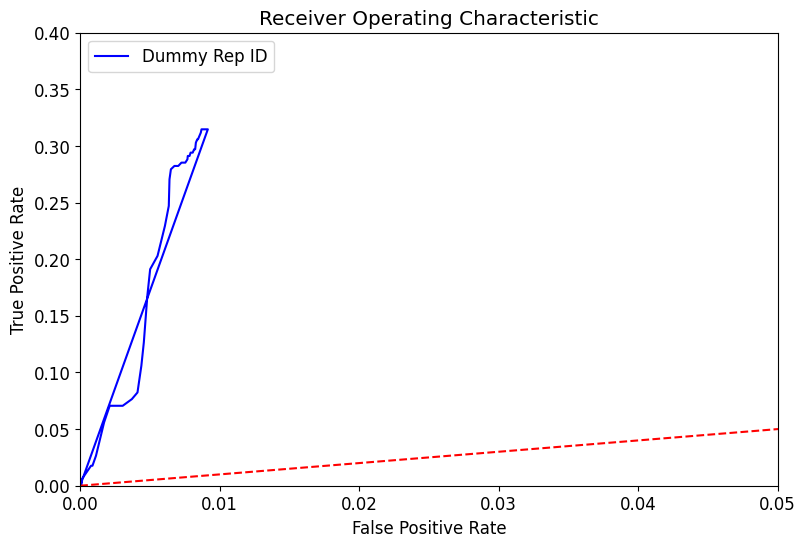

In [74]:
plt.rcParams.update({'font.size': 12})
fig = plt.figure(figsize=(9, 6), dpi=100)


fpr = rep_rates[:, 0]
tpr = rep_rates[:, 1]

# fpr = [0.01, 0.02]
# tpr = [0.2, 0.3]

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b')

# FIX LEGEND NAMES
plt.legend(["Dummy Rep ID", "Naive HMM", "Baum-Welch HMM"], loc="upper left")
plt.plot([0, .4], [0, .4],'r--')
plt.xlim([0, .05])
plt.ylim([0, .4])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

---
#### Code example with streamlined function (no longer correct filepath as hmm input is under construction)

In [1]:
# %%bash
# sh hmm.sh ../sim_example/rep_id_1_var_pos.csv.gz ../sim_example/rep_id_1_geno_mat.csv.gz ../sim_example/rep_id_1_intro_pos.csv.gz hmm_function_results.csv.gz

In [49]:
# Check if the two output files are the same
# reading files
f1 = open('/Users/briankirz/Documents/GitHub/mentee_research/kirz/site_pattern_hmm/sim_example_results/1_rep_workflow_results.txt', "r")  
f2 = open('/Users/briankirz/Documents/GitHub/mentee_research/kirz/site_pattern_hmm/sim_example_results/1_rep_workflow_results_CN.txt', "r")  
  
i = 0

# Boolean tracking identity
identical = True

for line1 in f1:
    i += 1
      
    for line2 in f2: 
        # matching line1 from both files
        if line1 != line2:  
            identical = False
            print("Line ", i, ":")
            # else print that line from both files
            print("\tFile 1:", line1, end='')
            print("\tFile 2:", line2, end='')
        break
  
# closing files
f1.close()                                       
f2.close()  

if identical:
    print("Both files are identical!")


Both files are identical!


---
### Workflow function

#### Done step by step

#### Once as a large function, compare its output to